In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import Sequential
import numpy as np
import matplotlib.pyplot as plt

In [2]:
split =['train[:80%]', 'train[20%:]']
(train_dataset, val_dataset), info = tfds.load('cats_vs_dogs', split=split, with_info=True, as_supervised=True)

print(info)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cats_vs_dogs/4.0.1.incompleteU9MN80/cats_vs_dogs-train.tfrecord*...:   0%|…

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.1. Subsequent calls will reuse this data.
tfds.core.DatasetInfo(
    name='cats_vs_dogs',
    full_name='cats_vs_dogs/4.0.1',
    description="""
    A large set of images of cats and dogs. There are 1738 corrupted images that are dropped.
    """,
    homepage='https://www.microsoft.com/en-us/download/details.aspx?id=54765',
    data_dir=PosixGPath('/tmp/tmpxltzk3kvtfds'),
    file_format=tfrecord,
    download_size=786.67 MiB,
    dataset_size=1.04 GiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'image/filename': Text(shape=(), dtype=string),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=23262, num_shards=16>,
    },
    citation="""@Inproceedings (Conference){asirra-a-captcha-that-exploits-in

In [3]:
info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'image/filename': Text(shape=(), dtype=string),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
})

In [4]:
def preprocess(image, label):
  image = tf.image.resize(image, [300, 300])
  return image, label

batched_train = train_dataset.map(preprocess).batch(32).prefetch(tf.data.experimental.AUTOTUNE)
batched_val = val_dataset.map(preprocess).batch(32).prefetch(tf.data.experimental.AUTOTUNE)

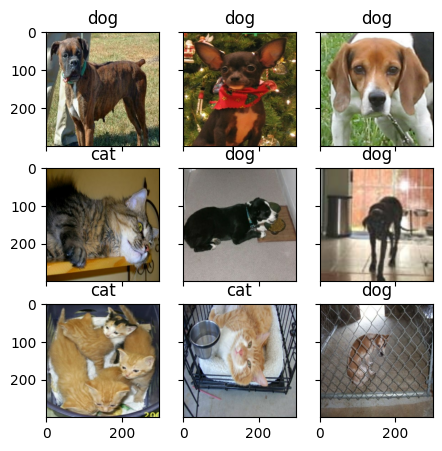

In [5]:
fig, ax = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(5,5))

for sample in batched_train.take(1):
  #print(sample)
  images, labels = sample[0], sample[1]
  for i in range(3):
    for j in range(3):
      ax[i][j].imshow(images[i*3+j].numpy().astype("uint8"))
      ax[i][j].set_title(info.features["label"].int2str(labels[i*3+j]))

plt.show()

In [6]:
data, metadata = tfds.load("cats_vs_dogs", with_info=True, split='train', shuffle_files=True)
batched_data = data.batch(32)

In [7]:
batched_train.take(1)

<_TakeDataset element_spec=(TensorSpec(shape=(None, 300, 300, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [8]:
out_height, out_width = 128,256
crop = tf.keras.layers.RandomCrop(out_height, out_width)
zoom = tf.keras.layers.RandomZoom(0.3)
rotate = tf.keras.layers.RandomRotation(0.3)
translate = tf.keras.layers.RandomTranslation(height_factor=0.2, width_factor=0.2)
flip = tf.keras.layers.RandomFlip()
contrast = tf.keras.layers.RandomContrast(0.2)


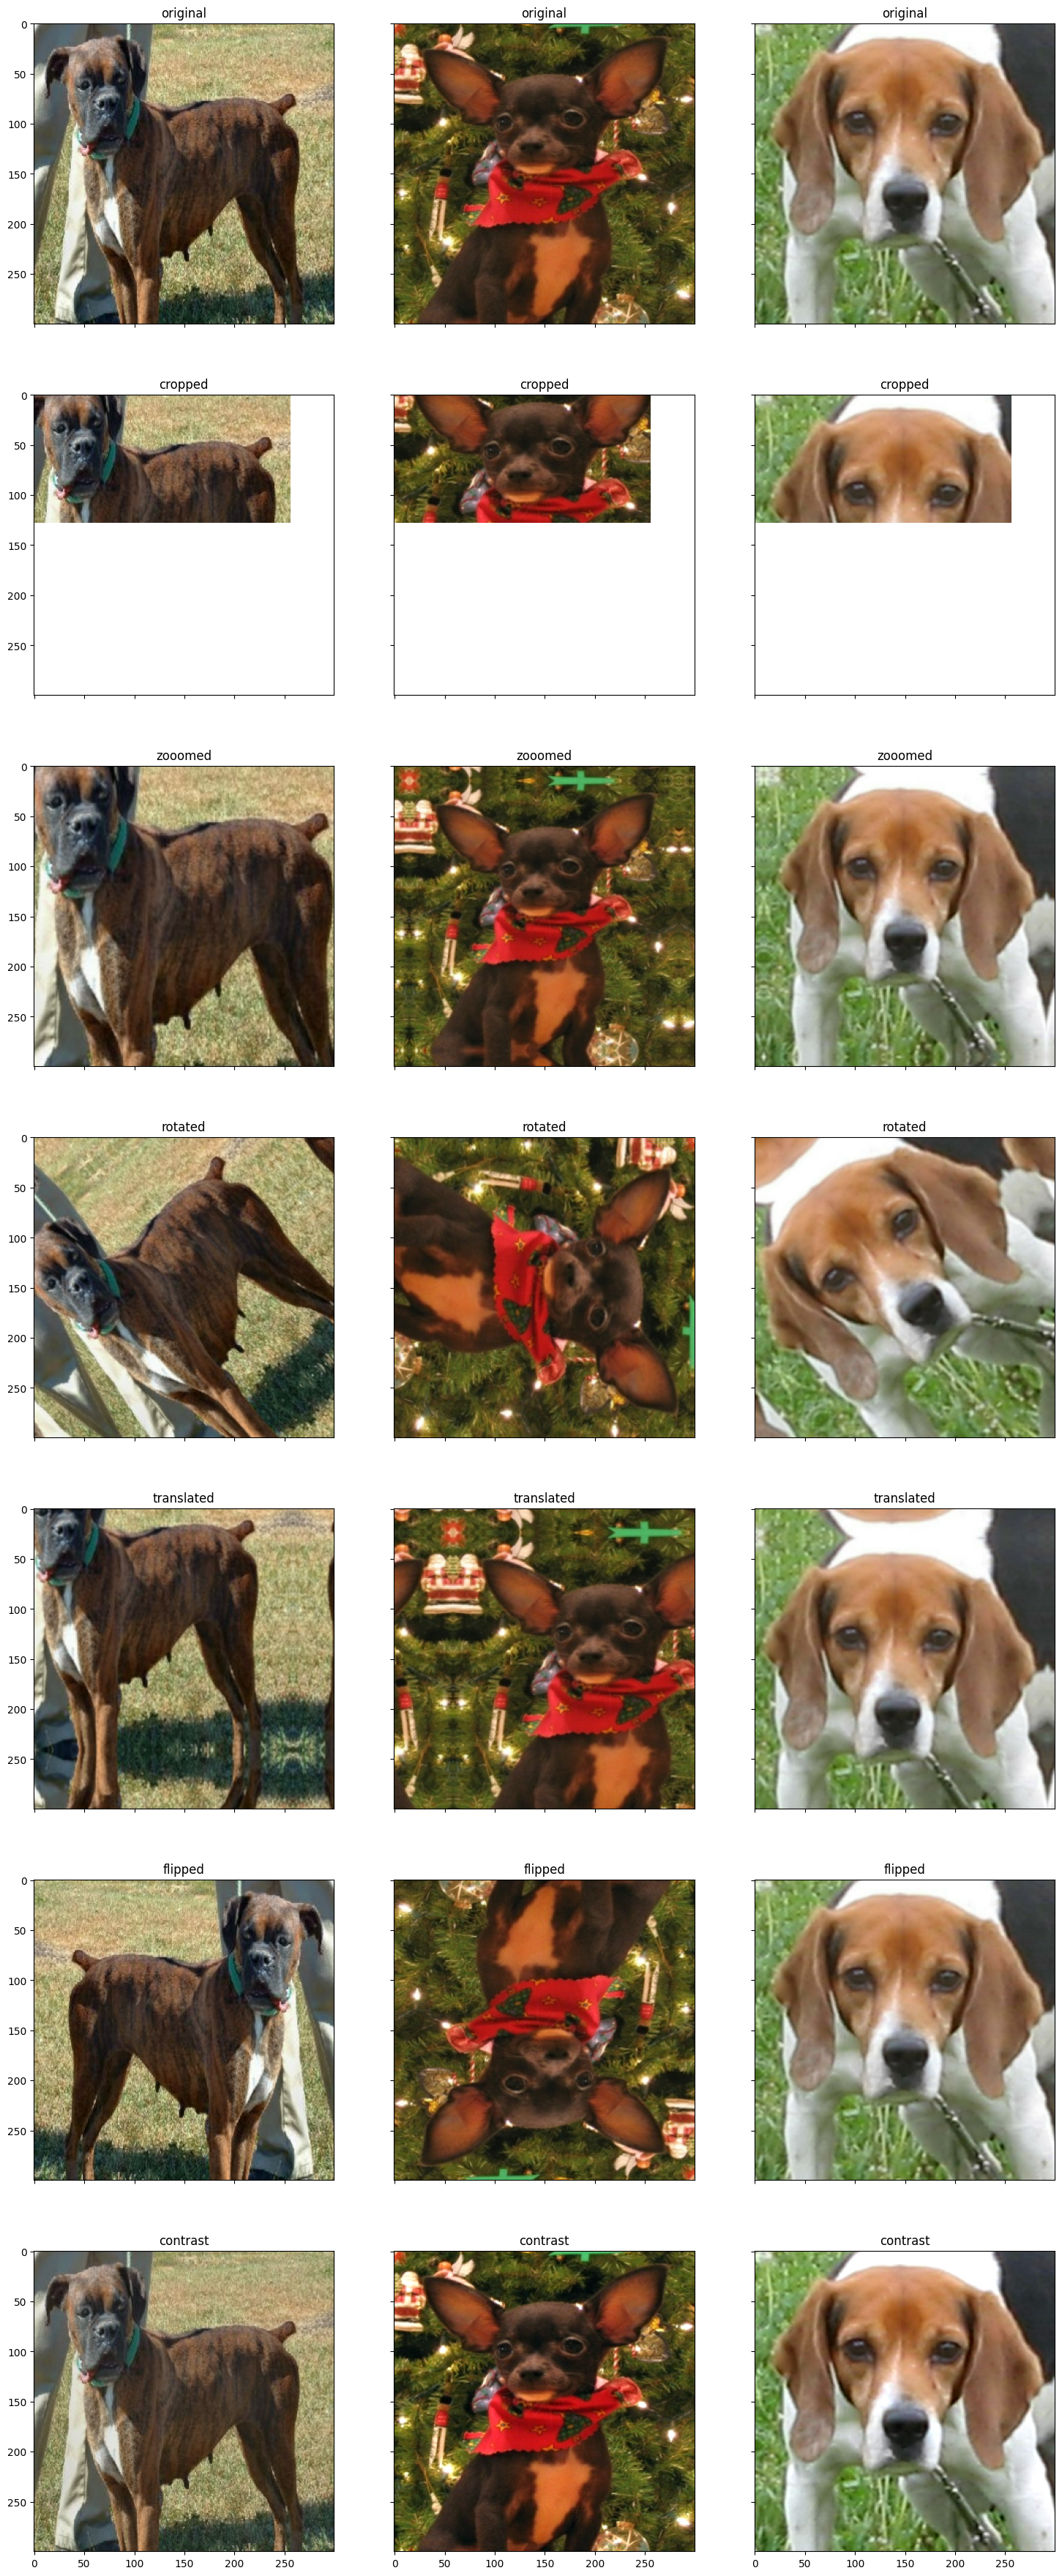

In [9]:
fig, ax = plt.subplots(7, 3, sharex=True, sharey=True, figsize=(18,45))

for sample in batched_train.take(1):
  images, labels = sample[0], sample[1]
  for i in range(3):
    ax[0][i].imshow(images[i].numpy().astype("uint8"))
    ax[0][i].set_title('original')
    # cropped
    ax[1][i].imshow(crop(images[i]).numpy().astype("uint8"))
    ax[1][i].set_title('cropped')
    # zoomed
    ax[2][i].imshow(zoom(images[i]).numpy().astype("uint8"))
    ax[2][i].set_title('zooomed')
    # rotated
    ax[3][i].imshow(rotate(images[i]).numpy().astype("uint8"))
    ax[3][i].set_title('rotated')
    # translated
    ax[4][i].imshow(translate(images[i]).numpy().astype("uint8"))
    ax[4][i].set_title('translated')
    # flipped
    ax[5][i].imshow(flip(images[i]).numpy().astype("uint8"))
    ax[5][i].set_title('flipped')
    # contrast
    ax[6][i].imshow(contrast(images[i]).numpy().astype("uint8"))
    ax[6][i].set_title('contrast')

In [10]:
def normalize(image, label):
  image = image / 255
  return image, label

normalized_train = batched_train.map(normalize)
normalized_val = batched_val.map(normalize)

In [11]:
model = Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(300, 300, 3)),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [12]:
def preprocess_norm(image, label):
  image = tf.image.resize(image, [300, 300])
  image = image / 255.0
  return image, label

norm_train = train_dataset.map(preprocess_norm).batch(32).prefetch(tf.data.experimental.AUTOTUNE)
norm_val = val_dataset.map(preprocess_norm).batch(32).prefetch(tf.data.experimental.AUTOTUNE)

In [13]:
# Enable eager execution for more detailed error messages
#tf.config.run_functions_eagerly(True)

history = model.fit(norm_train, epochs=10, batch_size=32)

Epoch 1/10
582/582 [==============================] - 69s 104ms/step - loss: 0.6312 - acc: 0.6554
Epoch 2/10
582/582 [==============================] - 58s 99ms/step - loss: 0.4832 - acc: 0.7654
Epoch 3/10
582/582 [==============================] - 58s 99ms/step - loss: 0.3361 - acc: 0.8496
Epoch 4/10
582/582 [==============================] - 57s 98ms/step - loss: 0.1853 - acc: 0.9263
Epoch 5/10
582/582 [==============================] - 57s 98ms/step - loss: 0.1091 - acc: 0.9599
Epoch 6/10
582/582 [==============================] - 57s 98ms/step - loss: 0.0732 - acc: 0.9758
Epoch 7/10
582/582 [==============================] - 57s 98ms/step - loss: 0.0380 - acc: 0.9883
Epoch 8/10
582/582 [==============================] - 60s 103ms/step - loss: 0.0255 - acc: 0.9922
Epoch 9/10
582/582 [==============================] - 57s 98ms/step - loss: 0.0222 - acc: 0.9929
Epoch 10/10
582/582 [==============================] - 58s 100ms/step - loss: 0.0160 - acc: 0.9952


KeyError: 'accuracy'

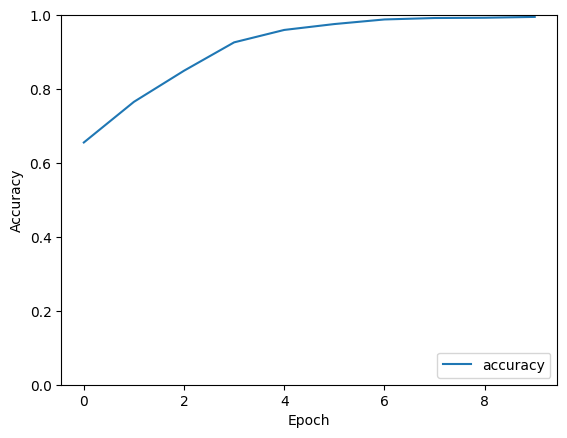

In [14]:
plt.plot(history.history['acc'], label='accuracy')
#plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()